In [1]:
""" process_RS_indicators.ipynb 

    Read in remote sensing indicator data, separate and preprocess to derive normalized gap sizes, percent foliage & bare soil, and vegetation heights by date for a site of interest 
    Currently configured to run for the following sites: NEAT1, NEAT2, NEAT3, Pullman, Moab, Mandan, Holloman, SanLuisValley 
    The gaps are read into bin sizes 0.375, 0.75, 1.5, and 2+, but these are just the names I've assigned to each bin 
    
    Author: Nicole Keeney 
    Date Created: 08-20-2021 
    Modification History: n/a 
    
"""

import pandas as pd 
import numpy as np 
from glob import glob 
import os 
import sys
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Import read_datetime_csv function from read_data module in the parent directory
sys.path.append('../utils')
from read_data_utils import read_datetime_csv

In [2]:
def read_gapsize_NEAT(data_dir):
    """ Read in gapsize data following csv conventions of NEAT sites
    Gapsize information is stored in the column name "rfPred"
    
    Args: 
        data_dir (str): Directory containing remote sensing indicator data (gap cover, vegetation height)
    
    Returns: 
        gapsize_df (pd.DataFrame): gapsize data for the following gaps (centimeters): 37.5, 75, 150, 200+
    
    """
    gapsize_df = pd.DataFrame() # Empty dataframe. Will add each column as each csv is read in 
    gaps = {"2":"0.375","5":"0.75","1":"1.5","3":"2+"} # Num corresponding to csv, followed by gap size (cm?)
    for csv_num, gapsize in gaps.items(): # Read in data for each csv and corresponding gap size 
        gapsize_filepath = glob(data_dir+"/*_GapCover_"+csv_num+".csv")[0]
        df = read_datetime_csv(gapsize_filepath)
        gapsize_df[gapsize] = df["rfPred"] # Add as column to main dataframe (i.e. adds column "37.5" to dataframe)
    gapsize_df.columns.name = "Gap size (m)" # Add descriptive name to columns 
    return gapsize_df

In [3]:
def read_hgt_NEAT(data_dir): 
    """ Read in vegetation height data following csv conventions of NEAT sites
    Veg height information is stored in the column name "rfPred"
    Veg height is converted from centimeters to meters 
    
    Args: 
        data_dir (str): Directory containing remote sensing indicator data (gap cover, vegetation height)
    
    Returns: 
        veg_hgt_df (pd.DataFrame): vegetation height data, with each column corresponding to a different vegetation type 
    
    """
    hgt_filepaths = glob(data_dir+"/*_Hgt_*.csv") # All filepaths with "Hgt" in the name 
    veg_hgt_df = pd.DataFrame() # Empty dataframe. Will add each column as each csv is read in 
    for filepath in hgt_filepaths: 
        df = read_datetime_csv(filepath)
        vegtype_str = filepath.split("Hgt_")[1].split(".csv")[0] # From filename, name of ecotype 
        veg_hgt_df[vegtype_str] = df["rfPred"] # Add as column to main dataframe (i.e. adds column "Sagebrush_hgt" to dataframe)
    veg_hgt_df = veg_hgt_df/100 # Convert cm -> m
    veg_hgt_df.columns.name = "Vegetation height (m)"
    
    # Rename columns 
    veg_dict = {'Forb_A': 'forb_hgt', 
                'Herbac': 'herbac_hgt', 
                'NonNox': 'non_nox_hgt', 
                'NonSag': 'non_sag_hgt', 
                'NoxPer': 'nox_per_hgt', 
                'Pere_1': 'pere_1_hgt', 
                'PerenF': 'perenf_hgt', 
                'PerenG': 'peren_g_hgt', 
                'Sagebr': 'sagebr_hgt', 
                'ShortP': 'short_p_hgt', 
                'TallPe': 'tall_p_hgt', 
                'Woody_': 'woody_hgt', 
                'Grass_': 'grass_hgt'}
    veg_hgt_df = veg_hgt_df.rename(columns=veg_dict)
    
    return veg_hgt_df 

In [4]:
def read_tot_fol_NEAT(data_dir): 
    """ Read in percent foliage and bare soil coverage by date for NEAT sites 
    
    Args: 
        data_dir (str): Directory containing remote sensing indicator data (gap cover, vegetation height)
    
    Returns: 
        fol_cover_df (pd.DataFrame): foliage and bare soil percentage by date 
    
    """
    # Empty df to add columns to 
    fol_cover_df = pd.DataFrame()
    
    # Read in foliage data 
    foliage_filepath = glob(data_dir+"/*TotalFolia*.csv")[0]  
    fol_df = read_datetime_csv(foliage_filepath)
    fol_cover_df["foliageCover"] = fol_df["rfPred"]
    
    # Read in bare soil cover data 
    bareSoil_filepath = glob(data_dir+"/*BareSoilCo*.csv")[0]
    soil_df = read_datetime_csv(bareSoil_filepath)
    fol_cover_df["bareSoilCover"] = soil_df["rfPred"]
    
    # Add descriptive column name
    fol_cover_df.columns.name = "Percent coverage"
    
    return fol_cover_df

In [5]:
def read_NEAT_data(data_dir): 
    """ Read NEAT data 
    Combines several functions to streamline code 
    
    Args: 
        data_dir (str): Directory containing remote sensing indicator data (gap cover, vegetation height)
    
    Return: 
        veg_hgt_df (pd.DataFrame): vegetation heights at the site by date 
        gapsize_df (pd.DataFrame): gap cover at the site by date 
        fol_cover_df (pd.DataFrame): percent foliage and bare soil coverage at the site by date 
    
    """
    # Raise error if directory does not exist
    if os.path.isdir(data_dir) == False: 
        raise ValueError("Directory does not exist: "+data_dir)
    
    # Read in data 
    gapsize_df = read_gapsize_NEAT(data_dir=data_dir)
    veg_hgt_df = read_hgt_NEAT(data_dir=data_dir)
    fol_cover_df = read_tot_fol_NEAT(data_dir=data_dir)
    
    return veg_hgt_df, gapsize_df, fol_cover_df 

In [6]:
def read_site_data(data_path, site_name): 
    """ Read in non-NEAT data for site of interest 
    
    Args: 
        data_path (str): path to csv file containing vegetation height and gap size data 
        site_name (str): name of site to grab data for ("Pullman","Holloman","SanLuisValley","Mandan","Moab")
    
    Return: 
        veg_hgt_df (pd.DataFrame): vegetation heights at the site by date 
        gapsize_df (pd.DataFrame): gap cover at the site by date 
        fol_cover_df (pd.DataFrame): percent foliage and bare soil coverage at the site by date 
    
    """
    # Raise error if file does not exist
    if os.path.isfile(data_path) == False: 
        raise ValueError("File does not exist: "+data_path)
    
    # Read in data 
    dfAll = read_datetime_csv(data_path)
    dfAll = dfAll.replace(to_replace="Hollomon",value="Holloman",regex=True) # Abi misspelled Holloman :(
    dfAll = dfAll.replace(to_replace="SLV",value="SanLuisValley",regex=True) # Extend acronym 
    df_site = dfAll[dfAll["loc"].str.contains(site_name)].sort_index()
    if len(df_site) == 0: 
        raise ValueError("Sitename "+site_name+" does not exist")
    
    # Separate data 
    new_col_names = {"GC2550":"0.375","GC51100":"0.75","GC101200":"1.5","GC200Plus":"2+",
                      "BGC":"bareSoilCover", "TFC":"foliageCover","HGA":"grass_hgt", "HHA":"herbac_hgt", "HWA":"woody_hgt", "HFA":"forb_hgt"}
    df_site = df_site.rename(columns=new_col_names)  # Rename columns to be more descriptive
    gapsize_df = df_site[["0.375","0.75","1.5","2+"]]
    veg_hgt_df = df_site[["grass_hgt","herbac_hgt","woody_hgt","forb_hgt"]]
    fol_cover_df = df_site[["bareSoilCover","foliageCover"]]
    
    # Convert vegetation height cm -> m
    veg_hgt_df = veg_hgt_df/100
    
     # Add descriptive name to columns 
    gapsize_df.columns.name = "Gap size (m)"
    veg_hgt_df.columns.name = "Vegetation height (m)"
    fol_cover_df.columns.name = "Percent coverage"
    
    return veg_hgt_df, gapsize_df, fol_cover_df 

In [7]:
def compute_normalized_gapsize(gapsize_df): 
    """ Normalize gap size for each date by dividing each gap size value by the date's sum of values for all 4 gap sizes 
    The sum of each row (i.e. each date) in the final output dataframe gapsize_norm_df will give 1.0 
    
    Args: 
        gapsize_df (pd.DataFrame): Dataframe with gapsizes as column values and datetime index 
        
    Returns: 
        gapsize_norm_df (pd.DataFrame): Dataframe of same format as gapsize_df, but with normalized gapsize values 
    """
    # Get sum of each date column (i.e. for 2008-04-01, add the gapsizes for the columns 0.375, 0.75, 1.5,and 2+ to get total gap size)
    sum_by_date = gapsize_df.sum(axis=1) 

    # Transpose dataframe to get dates as columns and gap sizes by rows. 
    # This allows you to divide by the total column sum to normalize each value for that date
    gapsize_df_dates_as_columns = gapsize_df.T 

    # Normalize, and transpose again to get original format (dates as rows, gap sizes as columns)
    gapsize_norm_df = (gapsize_df_dates_as_columns / sum_by_date).T
    gapsize_norm_df.columns.name = "Normalized gap size (m)"
    
    return gapsize_norm_df 

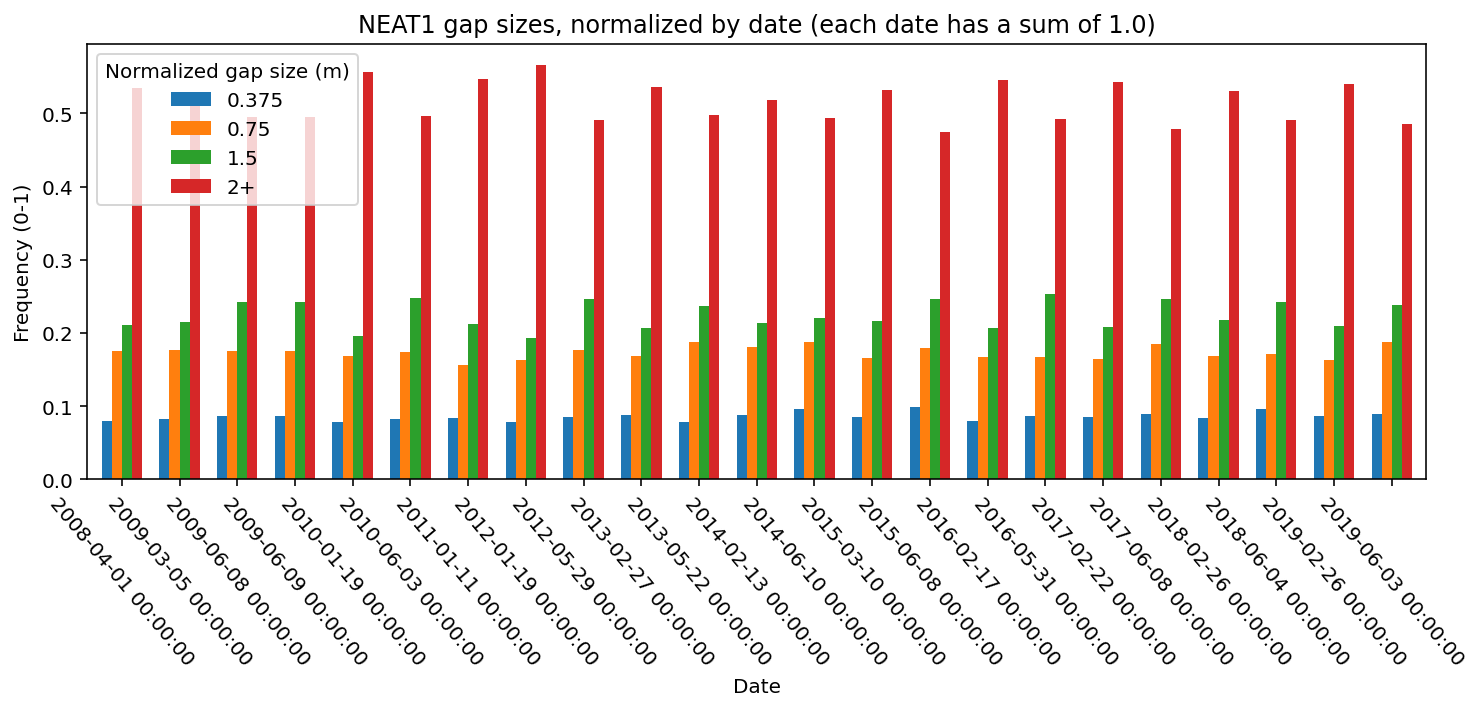

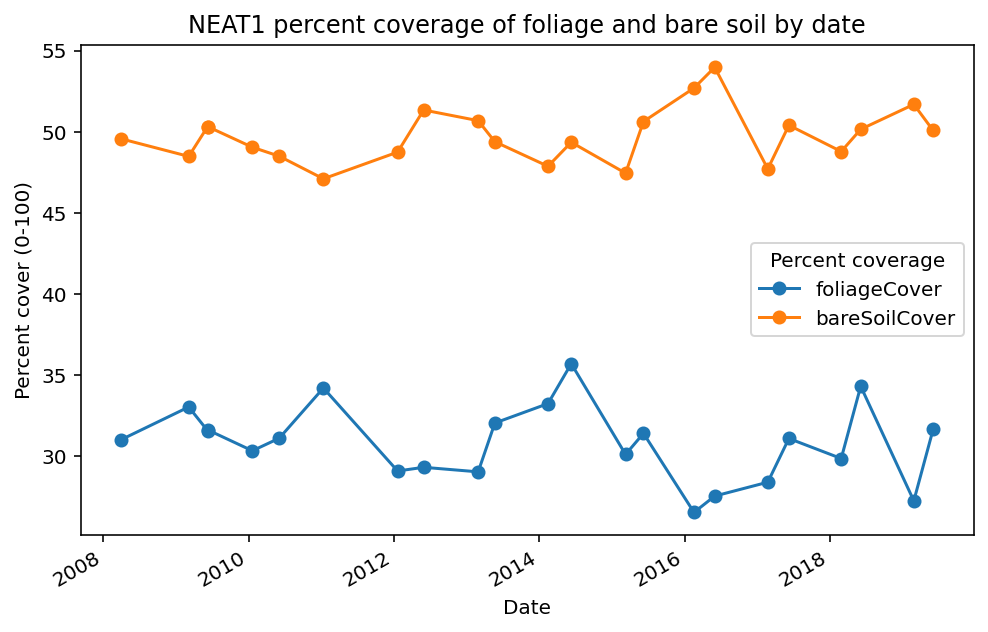

In [8]:
# ------------------- Input site name of interest -------------------
# You need to run this cell for each site 

site_name = "NEAT1" 
#site_name = "NEAT2"
#site_name = "NEAT3"
#site_name = "Moab"
#site_name = "Pullman"
#site_name = "Holloman"
#site_name = "Mandan"
#site_name = "SanLuisValley"

show_plots = True # Display some plots to visualize the results? 


# ------------------- Read in data by site name -------------------

data_dir = "../data/site_data/" # Main directory containing site data 
rs_indicators_dir = data_dir+site_name+"/RS_indicators" # Data containing raw RS indicator data (for NEAT sites only), and directory to store output files 

# Read in data for NEAT sites. Data is stored in the RS_indicators folder for each site 
if "NEAT" in site_name: 
    veg_hgt_df, gapsize_df, fol_cover_df = read_NEAT_data(data_dir=rs_indicators_dir+"/raw")

# Read in data for "Pullman","Holloman","SanLuisValley","Mandan","Moab" sites. Data is stored in one single csv file 
else: 
    path = data_dir+"site_data_combined/gapcover_vhgt_rf.csv" # Except for the NEAT sites, all the other sites are stored in one csv 
    veg_hgt_df, gapsize_df, fol_cover_df = read_site_data(data_path=path, site_name=site_name) # Read in data   

    
# ------------------- Compute normalized gap sizes -------------------
# Normalized gap sizes gives the fractional gap size for each gap size bin for a given date 
# See the function compute_normalized_gapsize for more information 

gapsize_norm_df = compute_normalized_gapsize(gapsize_df)


# ------------------- Save files as csv to local drive -------------------

gap_filename = site_name+"_gapsize_norm.csv"
gapsize_norm_df.to_csv(path_or_buf=rs_indicators_dir+"/"+gap_filename) # Normalized gap sizes by gap size bin 

veg_filename = site_name+"_veg_hgts.csv"
veg_hgt_df.to_csv(path_or_buf=rs_indicators_dir+"/"+veg_filename)# Veg heights by vegetation type 

fol_filename = site_name+"_perc_fol_cover.csv"
fol_cover_df["foliageCover"].to_csv(path_or_buf=rs_indicators_dir+"/"+fol_filename) # Percent foliage cover by date 

# ------------------- Make some nice plots! -------------------
if show_plots: 
    gapsize_norm_df.plot.bar(figsize=(12,4), width=0.7, ylabel="Frequency (0-1)", rot=-50, 
                             title=site_name+" gap sizes, normalized by date (each date has a sum of 1.0)");
    
    fol_cover_df.plot(figsize=(8,5), marker="o", ylabel="Percent cover (0-100)", 
                  title=site_name+" percent coverage of foliage and bare soil by date");